In [1]:
import rasterio as rio
import numpy as np
import pandas as pd
from rasterio.enums import Resampling

# --- Rutas individuales ---
ruta_inventario = r"C:\Users\Santi-PC\Desktop\Con fe se puede\Variables\IMM.tif"
ruta_pendiente  = r"C:\Users\Santi-PC\Desktop\Con fe se puede\Variables\slope.tif"
ruta_aspecto    = r"C:\Users\Santi-PC\Desktop\Con fe se puede\Carto_new\Aspect_Fill_1.tif"
ruta_elevacion  = r"C:\Users\Santi-PC\Desktop\Con fe se puede\Carto_new\DEM.tif"

# --- Raster base (inventario) ---
r_inventario = rio.open(ruta_inventario)
inventario = r_inventario.read(1)

height, width = r_inventario.height, r_inventario.width

def leer_y_resamplear(ruta, shape, ref):
    with rio.open(ruta) as src:
        return src.read(
            1,
            out_shape=(1, shape[0], shape[1]),
            resampling=Resampling.nearest
        )

# Resamplear al shape del inventario
pendiente  = leer_y_resamplear(ruta_pendiente, (height, width), r_inventario)
aspecto    = leer_y_resamplear(ruta_aspecto, (height, width), r_inventario)
elevacion  = leer_y_resamplear(ruta_elevacion, (height, width), r_inventario)

# --- Reemplazar valores inválidos ---
pendiente  = np.where(pendiente < -100, np.nan, pendiente)
aspecto    = np.where(aspecto < -100, np.nan, aspecto)
elevacion  = np.where(elevacion < -100, np.nan, elevacion)

# --- Crear máscara válida común ---
mascara_valida = (
    ~np.isnan(inventario) &
    ~np.isnan(pendiente) &
    ~np.isnan(aspecto) &
    ~np.isnan(elevacion)
)

# --- Aplicar máscara ---
inventario_vector = inventario[mascara_valida]
pendiente_vector  = pendiente[mascara_valida]
aspecto_vector    = aspecto[mascara_valida]
elevacion_vector  = elevacion[mascara_valida]

# --- Crear DataFrame ---
df = pd.DataFrame({
    'inventario': inventario_vector,
    'pendiente': pendiente_vector,
    'aspecto': aspecto_vector,
    'elevacion': elevacion_vector
})

# --- Resultado ---
print(df.shape)
print(list(df.columns))
print(df.head())



(85362, 4)
['inventario', 'pendiente', 'aspecto', 'elevacion']
   inventario  pendiente  aspecto  elevacion
0           0        0.0      0.0        0.0
1           0        0.0      0.0        0.0
2           0        0.0      0.0        0.0
3           0        0.0      0.0        0.0
4           0        0.0      0.0        0.0


In [2]:
from pandas import DataFrame
d={'inventario':inventario_vector,'pendiente':pendiente_vector,'aspecto':aspecto_vector, 'elevacion':elevacion_vector}
df2 = pd.DataFrame(d)
X=df2.drop("inventario", axis=1)
y=df2['inventario']
X.head()

,pendiente,aspecto,elevacion
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [3]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')

In [4]:
from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2)
print('Tamaño de variables de entrenamiento:', x_train.shape)
print('Tamaño de labels de entrenamiento:', y_train.shape)
print('Tamaño de variables de validación:', x_test.shape)
print('Tamaño de labels de validación:', y_test.shape)

Tamaño de variables de entrenamiento: (68289, 3)
Tamaño de labels de entrenamiento: (68289,)
Tamaño de variables de validación: (17073, 3)
Tamaño de labels de validación: (17073,)


In [5]:
result=model.fit(x_train,y_train)

In [6]:
y_train_pred=result.predict(x_train) # utiliza por defecto el valor de 0,5, por encime es uno y por debajo es 0
y_train_probs=result.predict_proba(x_train)[:,1]

In [7]:
y_val_pred=result.predict(x_test) 
y_val_probs=result.predict_proba(x_test)[:,1]

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[67039,    28],
       [   86,  1136]], dtype=int64)

In [9]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[67039,    28],
       [   86,  1136]], dtype=int64)

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67067
           1       0.98      0.93      0.95      1222

    accuracy                           1.00     68289
   macro avg       0.99      0.96      0.98     68289
weighted avg       1.00      1.00      1.00     68289



In [11]:
y_val_probs = model.predict_proba(x_test)[:, 1]


In [12]:
#from sklearn.metrics import roc_curve, auc

#fpr, tpr, thresholds = roc_curve(y_train, y_train_probs, pos_label=1)  # Ajusta si tu clase positiva no es 1
#roc_auc_val = auc(fpr_val, tpr_val)

In [13]:
import numpy as np
print("Valores únicos en y_test:", np.unique(y_test, return_counts=True))

Valores únicos en y_test: (array([0, 1], dtype=uint8), array([16751,   322], dtype=int64))


In [14]:
print("Longitud de y_test:", len(y_test))
print("Longitud de y_val_probs:", len(y_val_probs))

Longitud de y_test: 17073
Longitud de y_val_probs: 17073


In [15]:
print("Valores mínimos y máximos en y_val_probs:", np.min(y_val_probs), np.max(y_val_probs))
print("Primeros 10 valores:", y_val_probs[:10])

Valores mínimos y máximos en y_val_probs: 0.0 0.74
Primeros 10 valores: [0.11271943 0.         0.11271943 0.         0.11271943 0.11271943
 0.02       0.         0.07       0.        ]


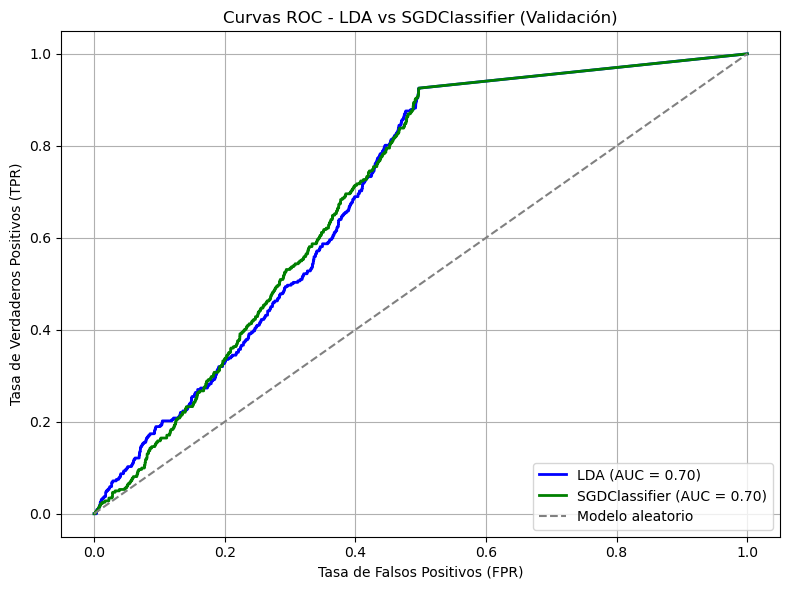

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 1. Modelo LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
lda_probs = lda.predict_proba(x_test)[:, 1]
fpr_lda, tpr_lda, _ = roc_curve(y_test, lda_probs, pos_label=1)
auc_lda = auc(fpr_lda, tpr_lda)

# 2. Modelo SGDClassifier (SVM lineal)
sgd = SGDClassifier(loss='hinge', max_iter=1000, class_weight='balanced', random_state=42)
sgd.fit(x_train, y_train)
sgd_scores = sgd.decision_function(x_test)  # No predict_proba, usamos scores
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, sgd_scores, pos_label=1)
auc_sgd = auc(fpr_sgd, tpr_sgd)

# --- Graficar solo LDA y SGD ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_lda, tpr_lda, lw=2, label='LDA (AUC = %0.2f)' % auc_lda, color='blue')
plt.plot(fpr_sgd, tpr_sgd, lw=2, label='SGDClassifier (AUC = %0.2f)' % auc_sgd, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Modelo aleatorio')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - LDA vs SGDClassifier (Validación)')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



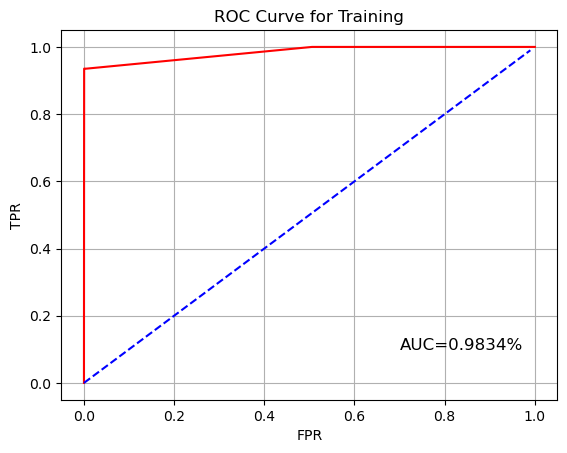

In [18]:
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs)
plt.plot(fpr, tpr, color='r')

xb = [i * 0.01 for i in range(100)]
yb = [i * 0.01 for i in range(100)]
plt.plot(xb, yb, linestyle='--', color='b')

plt.grid(True)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Training')

auc = str(round(metrics.auc(fpr, tpr), 4))
plt.text(x=0.7, y=0.1, s='AUC=' + auc + '%', size=12)

plt.show()


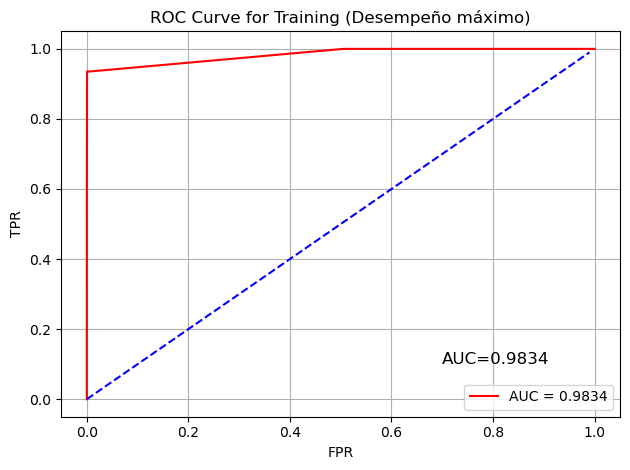

In [19]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Calcular la curva ROC directamente con las predicciones originales
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs)
auc_value = round(metrics.auc(fpr, tpr), 4)

# Graficar
plt.plot(fpr, tpr, color='r', label=f'AUC = {auc_value}')

# Línea de referencia (modelo sin capacidad predictiva)
xb = [i * 0.01 for i in range(100)]
yb = [i * 0.01 for i in range(100)]
plt.plot(xb, yb, linestyle='--', color='b')

plt.grid(True)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Training (Desempeño máximo)')
plt.text(x=0.7, y=0.1, s='AUC=' + str(auc_value), size=12)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [20]:
confusion_matrix(y_test, y_val_pred)

array([[16730,    21],
       [  316,     6]], dtype=int64)

In [21]:
print(classification_report(y_test,y_val_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16751
           1       0.22      0.02      0.03       322

    accuracy                           0.98     17073
   macro avg       0.60      0.51      0.51     17073
weighted avg       0.97      0.98      0.97     17073



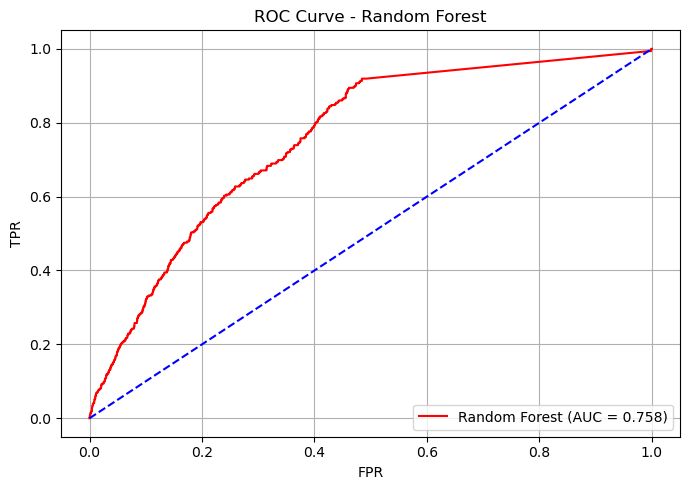

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Entrenar Random Forest con mejoras
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(x_train, y_train)

# Obtener probabilidades para la clase positiva
y_val_probs = rf_model.predict_proba(x_test)[:, 1]

# Calcular curva ROC y AUC
fpr, sensitivity, _ = roc_curve(y_test, y_val_probs)
auc_rf = auc(fpr, sensitivity)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, sensitivity, color='r', label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='b')
plt.grid(True)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import roc_curve, auc

In [25]:
##RED NEURONAL

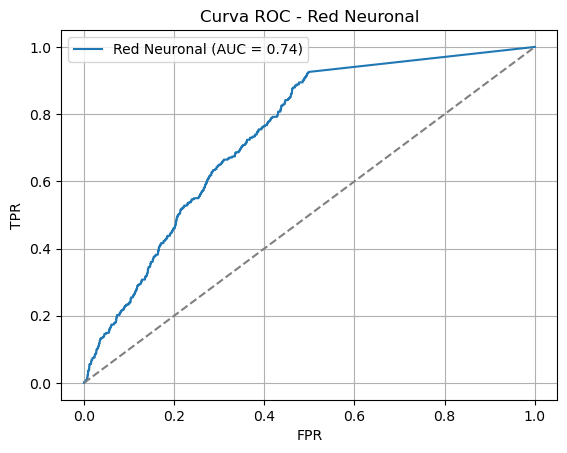

In [26]:
from sklearn.neural_network import MLPClassifier

# Entrenar red neuronal
nn_model = MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=500)
nn_model.fit(x_train, y_train)

# Probabilidades
nn_probs = nn_model.predict_proba(x_test)[:, 1]

# ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
auc_nn = auc(fpr_nn, tpr_nn)

# Plot
plt.figure()
plt.plot(fpr_nn, tpr_nn, label=f'Red Neuronal (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Red Neuronal')
plt.grid(True)
plt.legend()
plt.show()


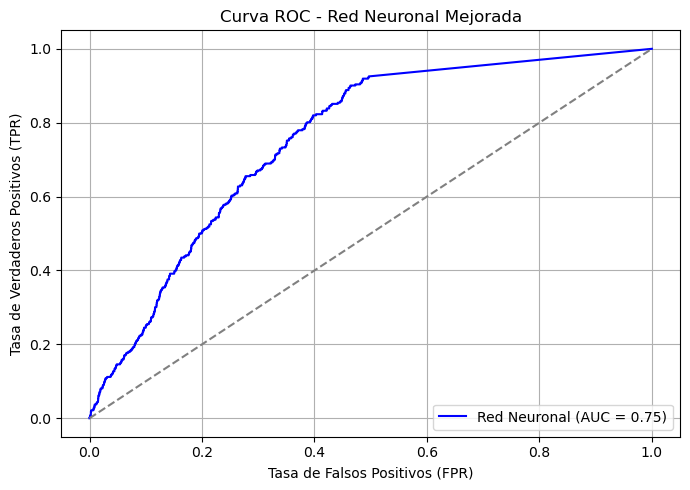

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Crear pipeline con escalado + red neuronal
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50, 30, 10), alpha=0.001, max_iter=1000, random_state=42))
])

# Entrenar el modelo
pipeline.fit(x_train, y_train)

# Obtener probabilidades del conjunto de prueba
nn_probs = pipeline.predict_proba(x_test)[:, 1]

# Calcular curva ROC y AUC
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
auc_nn = auc(fpr_nn, tpr_nn)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr_nn, tpr_nn, label=f'Red Neuronal (AUC = {auc_nn:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Red Neuronal Mejorada')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



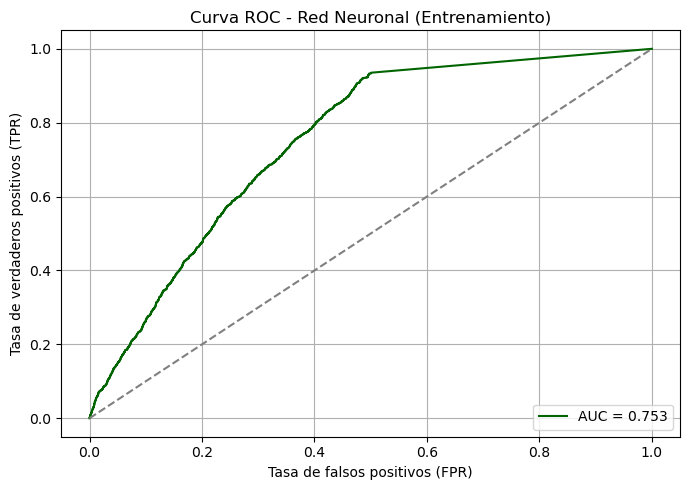

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Pipeline de entrenamiento de la red neuronal
nn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(20, 10), alpha=0.001, max_iter=1000, random_state=42))
])

# Entrenar con datos de entrenamiento
nn_pipeline.fit(x_train, y_train)

# Obtener probabilidades del entrenamiento (NO del test)
y_train_probs_nn = nn_pipeline.predict_proba(x_train)[:, 1]

# Calcular curva ROC y AUC del entrenamiento
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs_nn)
auc_train = auc(fpr_train, tpr_train)

# Graficar curva ROC del entrenamiento
plt.figure(figsize=(7, 5))
plt.plot(fpr_train, tpr_train, label=f'AUC = {auc_train:.3f}', color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Red Neuronal (Entrenamiento)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


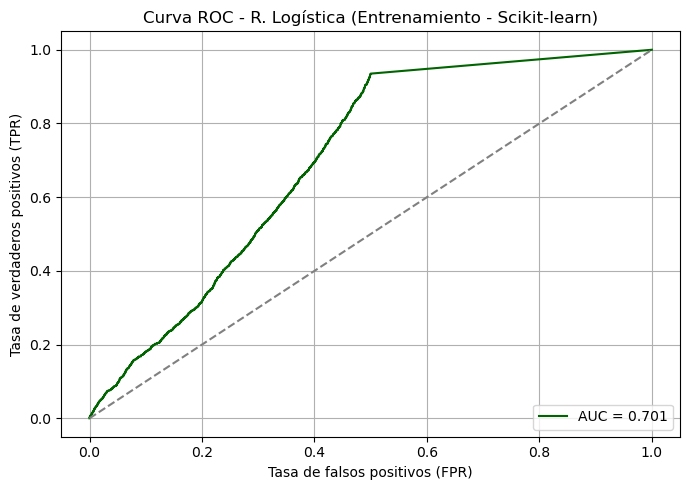

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Seleccionar variables predictoras y variable objetivo del entrenamiento
features = ['pendiente', 'aspecto', 'elevacion']
X_train_sel = x_train[features]
y_train_sel = y_train

# Crear pipeline con escalado + regresión logística balanceada
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',
        penalty='l2',
        class_weight='balanced',
        random_state=42
    ))
])

# Entrenar con el conjunto de entrenamiento
pipeline.fit(X_train_sel, y_train_sel)

# Predecir probabilidades para el mismo conjunto de entrenamiento
y_train_probs = pipeline.predict_proba(X_train_sel)[:, 1]

# Calcular curva ROC y AUC para entrenamiento
fpr, tpr, _ = roc_curve(y_train_sel, y_train_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - R. Logística (Entrenamiento - Scikit-learn)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



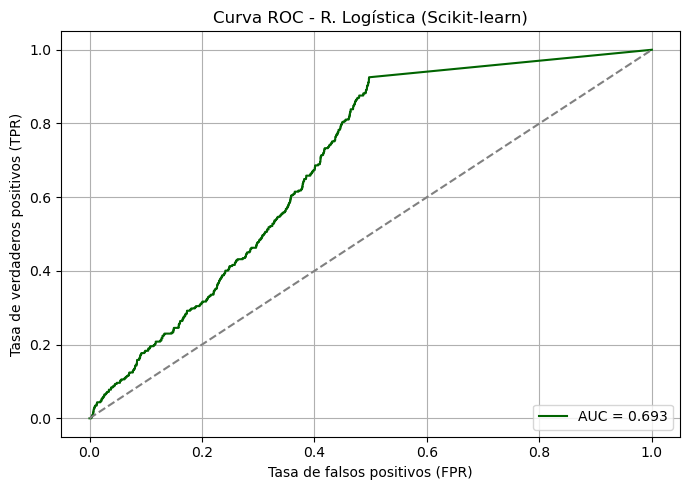

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Seleccionar las variables predictoras y la variable objetivo
features = ['pendiente', 'aspecto', 'elevacion']
X = x_test[features]  # Si x_test ya contiene todo, de lo contrario usar el dataset completo (X)
y = y_test            # Variable objetivo

# Dividir datos para entrenamiento si lo necesitas, si ya tienes X_train/X_test, puedes omitir esto
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear pipeline con escalado y regresión logística
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',
        penalty='l2',
        class_weight='balanced',
        random_state=42
    ))
])

# Entrenar el modelo
pipeline.fit(X, y)

# Predecir probabilidades (clase positiva)
p = pipeline.predict_proba(X)[:, 1]

# Calcular curva ROC y AUC
fpr, tpr, _ = roc_curve(y, p)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - R. Logística (Scikit-learn)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()




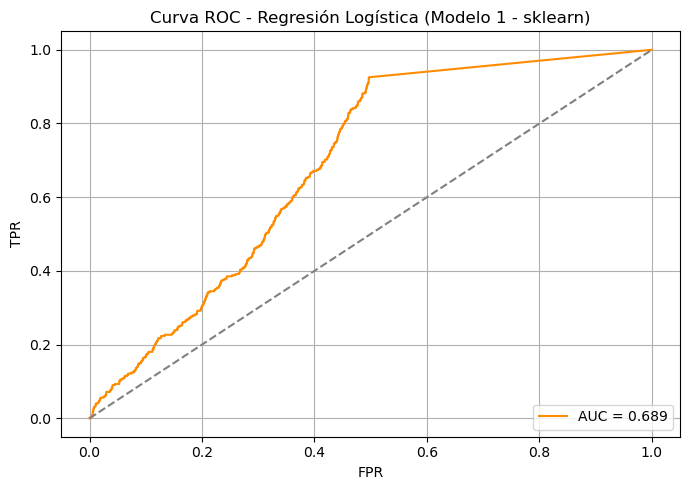

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Nos aseguramos de usar solo las columnas relevantes para este modelo
features = ['pendiente', 'aspecto', 'elevacion']
X_train_sel = x_train[features]
X_test_sel = x_test[features]

# Crear pipeline con escalado y modelo balanceado
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',
        penalty='l2',
        class_weight='balanced',
        random_state=42
    ))
])

# Entrenar y predecir
pipeline.fit(X_train_sel, y_train)
y_probs = pipeline.predict_proba(X_test_sel)[:, 1]

# Calcular y graficar la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Regresión Logística (Modelo 1 - sklearn)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()




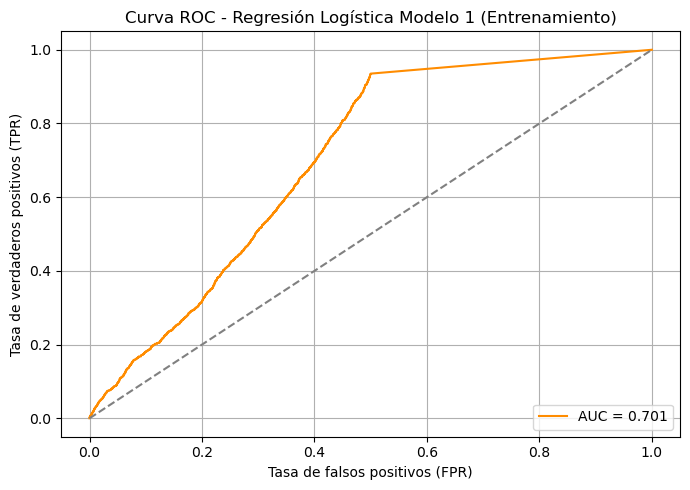

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Usar solo las columnas relevantes para el Modelo 2
features = ['pendiente', 'aspecto', 'elevacion']
X_train_sel = x_train[features]

# Crear pipeline con escalado y regresión logística balanceada
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',
        penalty='l2',
        class_weight='balanced',
        random_state=42
    ))
])

# Entrenar el modelo con el conjunto de entrenamiento
pipeline.fit(X_train_sel, y_train)

# Predecir probabilidades en el mismo conjunto de entrenamiento
y_train_probs = pipeline.predict_proba(X_train_sel)[:, 1]

# Calcular curva ROC y AUC para entrenamiento
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# Graficar curva ROC del entrenamiento
plt.figure(figsize=(7, 5))
plt.plot(fpr_train, tpr_train, label=f'AUC = {roc_auc_train:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Regresión Logística Modelo 1 (Entrenamiento)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

